In [1]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("sadmansakib7/ecg-arrhythmia-classification-dataset")

print("Path to dataset files:", path)

# load the dataset
df = pd.read_csv(path + "\MIT-BIH Arrhythmia Database.csv")     


c:\Users\Xian Zhang\Files\UF\Spring 2025\CIS 4930 Intro to Machine Learning\CIS4930-Final-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Xian Zhang\.cache\kagglehub\datasets\sadmansakib7\ecg-arrhythmia-classification-dataset\versions\1


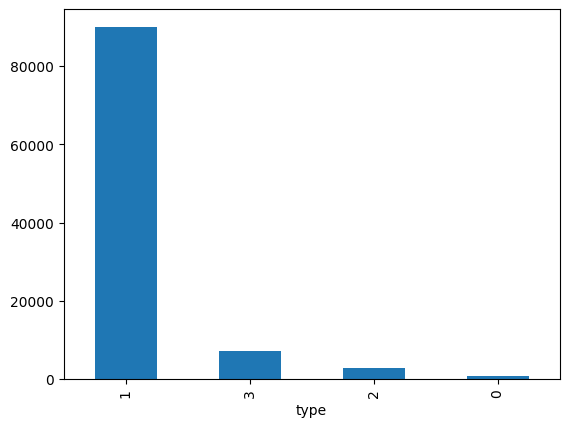

Dataset Shape: (100674, 33)

   type  0_pre-RR  0_post-RR   0_pPeak   0_tPeak   0_rPeak   0_sPeak  \
0     1        76      313.0  0.074347 -0.160548  1.036401 -0.285662   
1     1       313      315.0 -0.052079 -0.264784  0.886597 -0.366298   
2     1       315      321.0 -0.062151 -0.296983  0.991859 -0.410306   
3     1       321      336.0 -0.063322 -0.281386  1.034903 -0.403880   
4     1       336      344.0 -0.062915  1.046914  1.046408  1.046408   

    0_qPeak  0_qrs_interval  0_pq_interval  ...   1_qPeak  1_qrs_interval  \
0 -0.026824              41             18  ...  0.025930               2   
1 -0.059710              21              4  ... -0.042009              26   
2 -0.065686              22              3  ...  0.009528               3   
3 -0.071750              22              4  ... -0.020536               6   
4 -0.074639              11              4  ...  0.016053              16   

   1_pq_interval  1_qt_interval  1_st_interval  1_qrs_morph0  1_qrs_morph1 

KeyError: "['record'] not found in axis"

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


# N (Normal):
# Description: Represents normal heartbeats. These are the most common and indicate a regular, healthy heartbeat pattern.
# Count: 90,083 instances in your dataset, indicating that normal heartbeats are the majority class.
# VEB (Ventricular Ectopic Beat):
# Description: These are premature heartbeats originating from the ventricles.
# Count: 7,009 instances, making it a minority class compared to normal beats.
# SVEB (Supraventricular Ectopic Beat):
# Description: These are premature heartbeats originating above the ventricles, often in the atria.
# Count: 2,779 instances, another minority class.
# F (Fusion Beat):
# Description: Fusion beats occur when a normal heartbeat and an ectopic beat occur at the same time
# Count: 803 instances, indicating it's a relatively rare occurrence in your dataset.
# Q (Unknown/Unclassified):
# Description: This category might represent beats that couldn't be classified into the other categories
# Count: 15 instances, making it the rarest class in your dataset, should be removed

# data visualization and preprocessing
# bar chart of class distribution
df['type'].value_counts().plot(kind='bar')
plt.show()

# Data exploration
print(f'Dataset Shape: {df.shape}\n')
print(df.head(5))
df.info()
df.describe()

#columns in dataset:
print(df.columns)
print(df['type'].value_counts()) 

# from the visualization, we can see that there are some classes with very few samples, and classes that don't do anything
df = df.drop(columns=['record'])

# drop type ==  Q, not enough samples to form worthwhile predictions
df = df[df['type'] != 'Q']

# Encode the 'type' column,  because the classes are not ordinal
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

# Print the mapping of classes to encoded values
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Split the data into features (X) and target (y)
# X contains all columns except 'type', which is our target variable
# y contains only the 'type' column which has been encoded to numeric values
X = df.drop('type', axis=1)
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data, to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)



In [3]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Initialize XGBoost classifier with specific parameters
# use_label_encoder=False: Avoid using the deprecated label encoder
# eval_metric='mlogloss': Use multiclass log loss as evaluation metric
# verbosity=0: Suppress verbose output
# random_state=42: Set seed for reproducibility
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)

# Train the XGBoost model on the training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Print the classification report
print("XGBoost Classification Report:")
# Use the original class names from the label encoder for better readability in the report
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

XGBoost Classification Report:
              precision    recall  f1-score   support

           F       0.89      0.87      0.88       163
           N       1.00      1.00      1.00     18017
        SVEB       0.93      0.89      0.91       573
         VEB       0.97      0.97      0.97      1382

    accuracy                           0.99     20135
   macro avg       0.94      0.93      0.94     20135
weighted avg       0.99      0.99      0.99     20135



In [4]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier with specific parameters
# n_estimators=100: Use 100 trees in the forest
# random_state=42: Set seed for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the Random Forest model on the training data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_scaled)

# Print the classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Random Forest Classification Report:
              precision    recall  f1-score   support

           F       0.91      0.80      0.85       163
           N       1.00      0.99      1.00     18017
        SVEB       0.91      0.90      0.90       573
         VEB       0.95      0.98      0.96      1382

    accuracy                           0.99     20135
   macro avg       0.94      0.92      0.93     20135
weighted avg       0.99      0.99      0.99     20135



In [7]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize the SVM classifier with RBF kernel for non-linear data
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train the SVM model on the resampled training data
svm_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

SVM Classification Report:
              precision    recall  f1-score   support

           F       0.48      0.93      0.63       163
           N       1.00      0.97      0.98     18017
        SVEB       0.57      0.94      0.71       573
         VEB       0.93      0.96      0.95      1382

    accuracy                           0.96     20135
   macro avg       0.75      0.95      0.82     20135
weighted avg       0.98      0.96      0.97     20135



In [8]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

# Create a VotingClassifier
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('svm', svm_model)
    ],
    voting='hard'  # 'hard' for majority voting, 'soft' for averaging probabilities
)

# Train the ensemble model
voting_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_voting = voting_model.predict(X_test_scaled)

# Evaluate the ensemble model
print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting, target_names=label_encoder.classes_))

Voting Classifier Classification Report:
              precision    recall  f1-score   support

           F       0.86      0.86      0.86       163
           N       1.00      0.99      1.00     18017
        SVEB       0.91      0.91      0.91       573
         VEB       0.97      0.98      0.97      1382

    accuracy                           0.99     20135
   macro avg       0.93      0.93      0.93     20135
weighted avg       0.99      0.99      0.99     20135

